<a href="https://colab.research.google.com/github/ester0926/Deep-Generative-Models/blob/main/%E4%BD%9C%E6%A5%AD2_%E6%AF%94%E8%BC%83_VAE%E3%80%81GAN%E3%80%81cGAN_%E8%88%87_Diffusion_Model_%E5%9C%A8_MNIST_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E7%94%9F%E6%88%90%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-10-06 03:21:32--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.101.139, 142.250.101.100, 142.250.101.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-10-06 03:21:32--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  67.1MB/s    in 0.3s    

2025-10-06 

In [ ]:
# 前置設定
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# 匯入必要套件
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random, time
from tqdm import tqdm
import torchvision.utils as vutils

# 設定隨機種子以確保可重現性
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 裝置設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超參數
batch_size = 128
image_size = 28
channels = 1
latent_dim = 20  # 用於 VAE
noise_dim = 100  # 用於 GAN 和 cGAN
num_classes = 10  # 用於 cGAN
epochs_vae = 50
epochs_gan = 50
epochs_cgan = 50
epochs_diffusion = 200
lr_vae = 1e-3
lr_gan = 2e-4
lr_cgan = 2e-4
lr_diffusion = 2e-4
beta1 = 0.5
patience = 10

# 資料載入
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# train/valid split
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# 顯示影像的函數
def show_images(images, title, nrow=10):
    grid = vutils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Diffusion 超參數
timesteps = 300
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def extract(a, t, x_shape):
    b = t.shape[0]
    out = a.gather(-1, t).reshape(b, *((1,) * (len(x_shape) - 1)))
    return out

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    return extract(sqrt_alphas_cumprod, t, x0.shape) * x0 + extract(sqrt_one_minus_alphas_cumprod, t, x0.shape) * noise

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 581kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.5MB/s]


訓練 VAE...


100%|██████████| 375/375 [00:16<00:00, 22.87it/s]


VAE Epoch 1/50, Loss: 1.4924 | Val: 1.1271 | Time: 18.72s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.45it/s]


VAE Epoch 2/50, Loss: 1.0238 | Val: 0.9478 | Time: 14.68s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.99it/s]


VAE Epoch 3/50, Loss: 0.9081 | Val: 0.8835 | Time: 14.84s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.41it/s]


VAE Epoch 4/50, Loss: 0.8650 | Val: 0.8550 | Time: 15.08s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.89it/s]


VAE Epoch 5/50, Loss: 0.8446 | Val: 0.8415 | Time: 15.00s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 28.94it/s]


VAE Epoch 6/50, Loss: 0.8325 | Val: 0.8312 | Time: 15.35s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.36it/s]


VAE Epoch 7/50, Loss: 0.8240 | Val: 0.8254 | Time: 14.69s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.22it/s]


VAE Epoch 8/50, Loss: 0.8176 | Val: 0.8232 | Time: 16.04s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.09it/s]


VAE Epoch 9/50, Loss: 0.8125 | Val: 0.8173 | Time: 14.80s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.83it/s]


VAE Epoch 10/50, Loss: 0.8084 | Val: 0.8131 | Time: 14.99s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.34it/s]


VAE Epoch 11/50, Loss: 0.8044 | Val: 0.8130 | Time: 14.71s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.45it/s]


VAE Epoch 12/50, Loss: 0.8007 | Val: 0.8075 | Time: 15.02s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.87it/s]


VAE Epoch 13/50, Loss: 0.7980 | Val: 0.8062 | Time: 15.08s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.41it/s]


VAE Epoch 14/50, Loss: 0.7958 | Val: 0.8046 | Time: 14.71s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.27it/s]


VAE Epoch 15/50, Loss: 0.7935 | Val: 0.8002 | Time: 14.76s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.47it/s]


VAE Epoch 16/50, Loss: 0.7906 | Val: 0.8004 | Time: 14.80s


100%|██████████| 375/375 [00:12<00:00, 30.07it/s]


VAE Epoch 17/50, Loss: 0.7894 | Val: 0.7973 | Time: 15.24s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.26it/s]


VAE Epoch 18/50, Loss: 0.7875 | Val: 0.7952 | Time: 15.24s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.31it/s]


VAE Epoch 19/50, Loss: 0.7863 | Val: 0.7947 | Time: 14.78s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.24it/s]


VAE Epoch 20/50, Loss: 0.7847 | Val: 0.7955 | Time: 14.87s


100%|██████████| 375/375 [00:12<00:00, 29.96it/s]


VAE Epoch 21/50, Loss: 0.7836 | Val: 0.7916 | Time: 15.33s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.23it/s]


VAE Epoch 22/50, Loss: 0.7819 | Val: 0.7927 | Time: 14.77s


100%|██████████| 375/375 [00:12<00:00, 30.11it/s]


VAE Epoch 23/50, Loss: 0.7809 | Val: 0.7920 | Time: 14.86s


100%|██████████| 375/375 [00:12<00:00, 30.26it/s]


VAE Epoch 24/50, Loss: 0.7798 | Val: 0.7908 | Time: 14.74s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.93it/s]


VAE Epoch 25/50, Loss: 0.7790 | Val: 0.7910 | Time: 15.52s


100%|██████████| 375/375 [00:12<00:00, 30.29it/s]


VAE Epoch 26/50, Loss: 0.7778 | Val: 0.7866 | Time: 14.76s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.26it/s]


VAE Epoch 27/50, Loss: 0.7770 | Val: 0.7912 | Time: 14.76s


100%|██████████| 375/375 [00:12<00:00, 29.49it/s]


VAE Epoch 28/50, Loss: 0.7763 | Val: 0.7868 | Time: 15.45s


100%|██████████| 375/375 [00:12<00:00, 30.09it/s]


VAE Epoch 29/50, Loss: 0.7752 | Val: 0.7870 | Time: 15.39s


100%|██████████| 375/375 [00:12<00:00, 30.39it/s]


VAE Epoch 30/50, Loss: 0.7746 | Val: 0.7853 | Time: 14.78s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 29.37it/s]


VAE Epoch 31/50, Loss: 0.7738 | Val: 0.7867 | Time: 15.22s


100%|██████████| 375/375 [00:12<00:00, 30.07it/s]


VAE Epoch 32/50, Loss: 0.7729 | Val: 0.7862 | Time: 14.86s


100%|██████████| 375/375 [00:12<00:00, 30.07it/s]


VAE Epoch 33/50, Loss: 0.7720 | Val: 0.7833 | Time: 15.46s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.24it/s]


VAE Epoch 34/50, Loss: 0.7720 | Val: 0.7840 | Time: 14.78s


100%|██████████| 375/375 [00:12<00:00, 30.27it/s]


VAE Epoch 35/50, Loss: 0.7714 | Val: 0.7844 | Time: 14.72s


100%|██████████| 375/375 [00:12<00:00, 30.51it/s]


VAE Epoch 36/50, Loss: 0.7703 | Val: 0.7840 | Time: 14.66s


100%|██████████| 375/375 [00:12<00:00, 30.34it/s]


VAE Epoch 37/50, Loss: 0.7698 | Val: 0.7819 | Time: 15.35s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.26it/s]


VAE Epoch 38/50, Loss: 0.7693 | Val: 0.7831 | Time: 15.34s


100%|██████████| 375/375 [00:12<00:00, 30.36it/s]


VAE Epoch 39/50, Loss: 0.7679 | Val: 0.7809 | Time: 14.73s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.40it/s]


VAE Epoch 40/50, Loss: 0.7677 | Val: 0.7829 | Time: 14.74s


100%|██████████| 375/375 [00:12<00:00, 30.37it/s]


VAE Epoch 41/50, Loss: 0.7669 | Val: 0.7804 | Time: 15.34s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.43it/s]


VAE Epoch 42/50, Loss: 0.7670 | Val: 0.7814 | Time: 14.66s


100%|██████████| 375/375 [00:12<00:00, 30.33it/s]


VAE Epoch 43/50, Loss: 0.7665 | Val: 0.7815 | Time: 14.70s


100%|██████████| 375/375 [00:12<00:00, 30.38it/s]


VAE Epoch 44/50, Loss: 0.7660 | Val: 0.7803 | Time: 14.71s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.44it/s]


VAE Epoch 45/50, Loss: 0.7654 | Val: 0.7810 | Time: 14.90s


100%|██████████| 375/375 [00:12<00:00, 30.05it/s]


VAE Epoch 46/50, Loss: 0.7652 | Val: 0.7792 | Time: 15.23s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.31it/s]


VAE Epoch 47/50, Loss: 0.7645 | Val: 0.7786 | Time: 14.74s
儲存最佳模型


100%|██████████| 375/375 [00:12<00:00, 30.22it/s]


VAE Epoch 48/50, Loss: 0.7641 | Val: 0.7826 | Time: 15.54s


100%|██████████| 375/375 [00:12<00:00, 29.91it/s]


VAE Epoch 49/50, Loss: 0.7636 | Val: 0.7805 | Time: 15.21s


100%|██████████| 375/375 [00:12<00:00, 28.94it/s]


VAE Epoch 50/50, Loss: 0.7635 | Val: 0.7800 | Time: 15.43s
總訓練時間: 754.30s


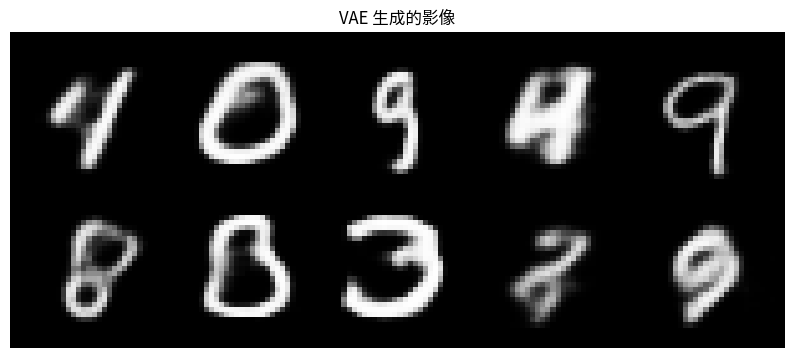

In [ ]:
# VAE 模型
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE 損失函數
def vae_loss(recon_x, x, mu, logvar):
    target = (x + 1) / 2
    BCE = F.binary_cross_entropy(recon_x, target, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 初始化模型
vae = VAE().to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=lr_vae)

# 訓練 VAE
def vae_loss_batch(x):
    recon_batch, mu, logvar = vae(x)
    loss = vae_loss(recon_batch, x, mu, logvar)
    return loss / x.size(0)  # 平均損失

best_val = float('inf')
early = 0
best_model_path = "vae_best.pth"
train_losses, valid_losses = [], []

print("訓練 VAE...")
total_start = time.time()
for epoch in range(1, epochs_vae + 1):
    ep_start = time.time()
    vae.train()
    train_loss_sum = 0.0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        loss = vae_loss_batch(data)
        optimizer_vae.zero_grad()
        loss.backward()
        optimizer_vae.step()
        train_loss_sum += loss.item()
    avg_train = train_loss_sum / len(train_loader.dataset)
    train_losses.append(avg_train)

    # validation
    vae.eval()
    val_sum = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            val_sum += vae_loss_batch(data).item()
    avg_val = val_sum / len(valid_loader.dataset)
    valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"VAE Epoch {epoch}/{epochs_vae}, Loss: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(vae.state_dict(), best_model_path)
        print("儲存最佳模型")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("早停觸發")
            break

total_time = time.time() - total_start
print(f"總訓練時間: {total_time:.2f}s")

# 生成 VAE 影像
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    vae_samples = vae.decode(z)
show_images(vae_samples, "VAE 生成的影像", nrow=5)

訓練 GAN...


100%|██████████| 375/375 [00:18<00:00, 19.83it/s]


GAN Epoch 1/50, Loss: 0.0173 | Val: 0.0168 | Time: 22.47s
儲存最佳模型


100%|██████████| 375/375 [00:19<00:00, 19.72it/s]


GAN Epoch 2/50, Loss: 0.0164 | Val: 0.0144 | Time: 22.34s
儲存最佳模型


100%|██████████| 375/375 [00:19<00:00, 18.89it/s]


GAN Epoch 3/50, Loss: 0.0163 | Val: 0.0160 | Time: 22.90s


100%|██████████| 375/375 [00:20<00:00, 18.63it/s]


GAN Epoch 4/50, Loss: 0.0162 | Val: 0.0155 | Time: 23.23s


100%|██████████| 375/375 [00:19<00:00, 18.92it/s]


GAN Epoch 5/50, Loss: 0.0162 | Val: 0.0163 | Time: 22.83s


100%|██████████| 375/375 [00:19<00:00, 18.99it/s]


GAN Epoch 6/50, Loss: 0.0164 | Val: 0.0179 | Time: 22.74s


100%|██████████| 375/375 [00:19<00:00, 19.66it/s]


GAN Epoch 7/50, Loss: 0.0163 | Val: 0.0157 | Time: 22.10s


100%|██████████| 375/375 [00:18<00:00, 19.77it/s]


GAN Epoch 8/50, Loss: 0.0164 | Val: 0.0146 | Time: 22.46s


100%|██████████| 375/375 [00:18<00:00, 20.20it/s]


GAN Epoch 9/50, Loss: 0.0164 | Val: 0.0169 | Time: 22.12s


100%|██████████| 375/375 [00:18<00:00, 19.91it/s]


GAN Epoch 10/50, Loss: 0.0166 | Val: 0.0178 | Time: 21.98s


100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


GAN Epoch 11/50, Loss: 0.0164 | Val: 0.0160 | Time: 22.34s


100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


GAN Epoch 12/50, Loss: 0.0169 | Val: 0.0159 | Time: 22.43s
早停觸發
總訓練時間: 269.98s


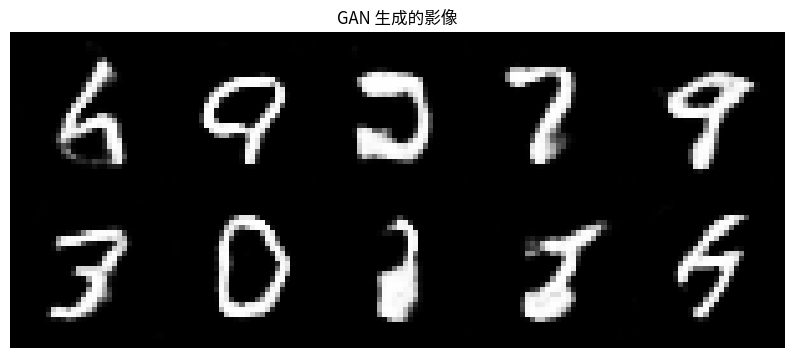

In [ ]:
# GAN 模型 - 升級為 CNN 版本
class GeneratorGAN(nn.Module):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256 * 7 * 7),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class DiscriminatorGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 初始化
generator_gan = GeneratorGAN().to(device)
discriminator_gan = DiscriminatorGAN().to(device)
optimizer_g = optim.Adam(generator_gan.parameters(), lr=lr_gan, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator_gan.parameters(), lr=lr_gan, betas=(beta1, 0.999))
criterion = nn.BCELoss()

# 訓練函數（包含參數更新）
def gan_train_step(images):
    images = images.to(device)
    real = torch.ones(images.size(0), 1).to(device)
    fake = torch.zeros(images.size(0), 1).to(device)

    # 訓練判別器
    optimizer_d.zero_grad()
    output_real = discriminator_gan(images)
    loss_real = criterion(output_real, real)
    z = torch.randn(images.size(0), noise_dim).to(device)
    fake_images = generator_gan(z)
    output_fake = discriminator_gan(fake_images.detach())
    loss_fake = criterion(output_fake, fake)
    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer_d.step()

    # 訓練生成器
    optimizer_g.zero_grad()
    output_fake = discriminator_gan(fake_images)
    loss_g = criterion(output_fake, real)
    loss_g.backward()
    optimizer_g.step()

    return loss_d.item() + loss_g.item()

# 驗證函數（只計算損失）
def gan_valid_step(images):
    images = images.to(device)
    real = torch.ones(images.size(0), 1).to(device)
    fake = torch.zeros(images.size(0), 1).to(device)

    # 只做前向傳播，不更新參數
    output_real = discriminator_gan(images)
    loss_real = criterion(output_real, real)

    z = torch.randn(images.size(0), noise_dim).to(device)
    fake_images = generator_gan(z)
    output_fake = discriminator_gan(fake_images)
    loss_fake = criterion(output_fake, fake)

    loss_d = loss_real + loss_fake

    # 生成器損失
    output_fake_for_g = discriminator_gan(fake_images)
    loss_g = criterion(output_fake_for_g, real)

    return (loss_d + loss_g).item()

# 訓練循環
best_val = float('inf')
early = 0
best_model_path_g = "gan_generator_best.pth"
best_model_path_d = "gan_discriminator_best.pth"
train_losses, valid_losses = [], []

print("訓練 GAN...")
total_start = time.time()
for epoch in range(1, epochs_gan + 1):
    ep_start = time.time()
    generator_gan.train()
    discriminator_gan.train()
    train_loss_sum = 0.0
    for images, _ in tqdm(train_loader):
        train_loss_sum += gan_train_step(images)
    avg_train = train_loss_sum / len(train_loader.dataset)
    train_losses.append(avg_train)

    # validation
    generator_gan.eval()
    discriminator_gan.eval()
    val_sum = 0.0
    with torch.no_grad():
        for images, _ in valid_loader:
            val_sum += gan_valid_step(images)
    avg_val = val_sum / len(valid_loader.dataset)
    valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"GAN Epoch {epoch}/{epochs_gan}, Loss: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(generator_gan.state_dict(), best_model_path_g)
        torch.save(discriminator_gan.state_dict(), best_model_path_d)
        print("儲存最佳模型")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("早停觸發")
            break

total_time = time.time() - total_start
print(f"總訓練時間: {total_time:.2f}s")

# 生成 GAN 影像
with torch.no_grad():
    z = torch.randn(10, noise_dim).to(device)
    gan_samples = generator_gan(z)
show_images(gan_samples, "GAN 生成的影像", nrow=5)

訓練 cGAN...


100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


cGAN Epoch 1/50, Loss: 0.0175 | Val: 0.0169 | Time: 25.52s
儲存最佳模型


100%|██████████| 375/375 [00:21<00:00, 17.09it/s]


cGAN Epoch 2/50, Loss: 0.0170 | Val: 0.0165 | Time: 25.28s
儲存最佳模型


100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


cGAN Epoch 3/50, Loss: 0.0170 | Val: 0.0170 | Time: 25.50s


100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


cGAN Epoch 4/50, Loss: 0.0171 | Val: 0.0172 | Time: 26.61s


100%|██████████| 375/375 [00:21<00:00, 17.56it/s]


cGAN Epoch 5/50, Loss: 0.0171 | Val: 0.0161 | Time: 25.20s
儲存最佳模型


100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


cGAN Epoch 6/50, Loss: 0.0171 | Val: 0.0165 | Time: 24.86s


100%|██████████| 375/375 [00:20<00:00, 17.87it/s]


cGAN Epoch 7/50, Loss: 0.0171 | Val: 0.0179 | Time: 24.83s


100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


cGAN Epoch 8/50, Loss: 0.0172 | Val: 0.0157 | Time: 24.75s
儲存最佳模型


100%|██████████| 375/375 [00:21<00:00, 17.77it/s]


cGAN Epoch 9/50, Loss: 0.0172 | Val: 0.0175 | Time: 24.68s


100%|██████████| 375/375 [00:21<00:00, 17.58it/s]


cGAN Epoch 10/50, Loss: 0.0173 | Val: 0.0169 | Time: 24.66s


100%|██████████| 375/375 [00:21<00:00, 17.69it/s]


cGAN Epoch 11/50, Loss: 0.0172 | Val: 0.0167 | Time: 24.54s


100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


cGAN Epoch 12/50, Loss: 0.0173 | Val: 0.0167 | Time: 24.56s


100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


cGAN Epoch 13/50, Loss: 0.0173 | Val: 0.0179 | Time: 25.28s


100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


cGAN Epoch 14/50, Loss: 0.0174 | Val: 0.0174 | Time: 24.64s


100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


cGAN Epoch 15/50, Loss: 0.0173 | Val: 0.0175 | Time: 24.86s


100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


cGAN Epoch 16/50, Loss: 0.0173 | Val: 0.0168 | Time: 24.54s


100%|██████████| 375/375 [00:21<00:00, 17.55it/s]


cGAN Epoch 17/50, Loss: 0.0174 | Val: 0.0173 | Time: 24.71s


100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


cGAN Epoch 18/50, Loss: 0.0174 | Val: 0.0155 | Time: 24.46s
儲存最佳模型


100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


cGAN Epoch 19/50, Loss: 0.0173 | Val: 0.0167 | Time: 24.74s


100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


cGAN Epoch 20/50, Loss: 0.0173 | Val: 0.0169 | Time: 24.77s


100%|██████████| 375/375 [00:21<00:00, 17.55it/s]


cGAN Epoch 21/50, Loss: 0.0174 | Val: 0.0166 | Time: 24.76s


100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


cGAN Epoch 22/50, Loss: 0.0173 | Val: 0.0176 | Time: 25.63s


100%|██████████| 375/375 [00:21<00:00, 17.46it/s]


cGAN Epoch 23/50, Loss: 0.0174 | Val: 0.0166 | Time: 24.78s


100%|██████████| 375/375 [00:21<00:00, 17.48it/s]


cGAN Epoch 24/50, Loss: 0.0175 | Val: 0.0169 | Time: 24.86s


100%|██████████| 375/375 [00:21<00:00, 17.56it/s]


cGAN Epoch 25/50, Loss: 0.0174 | Val: 0.0168 | Time: 24.83s


100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


cGAN Epoch 26/50, Loss: 0.0174 | Val: 0.0158 | Time: 24.88s


100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


cGAN Epoch 27/50, Loss: 0.0174 | Val: 0.0170 | Time: 24.91s


100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


cGAN Epoch 28/50, Loss: 0.0175 | Val: 0.0189 | Time: 24.76s
早停觸發
總訓練時間: 698.53s

生成 cGAN 影像：數字 0-9 各 10 張...


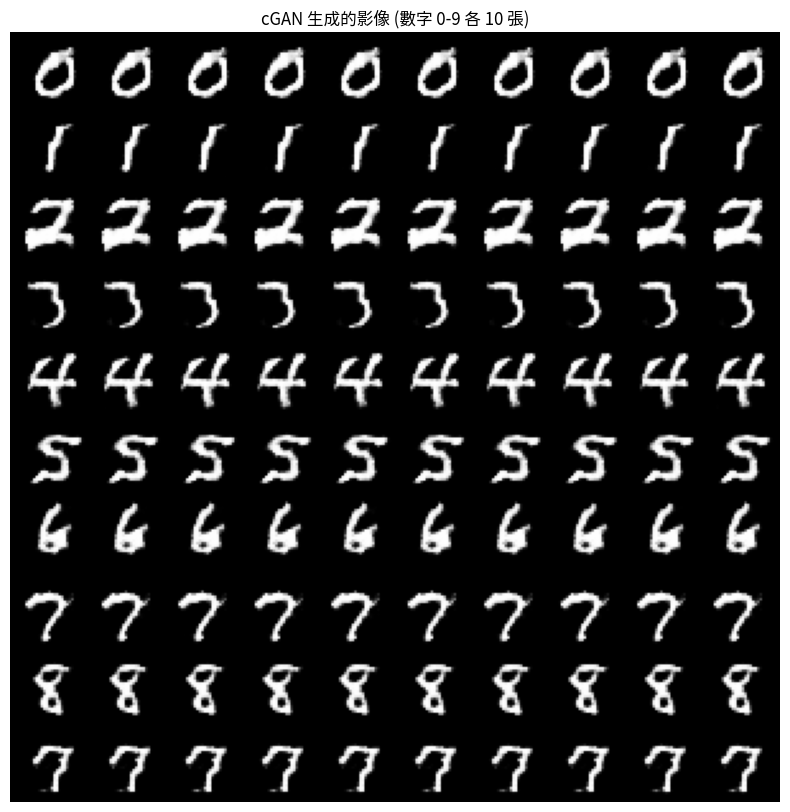

In [ ]:
# cGAN 模型 - 升級為 CNN 版本
class GeneratorCGAN(nn.Module):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        self.label_emb = nn.Embedding(num_classes, noise_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim * 2, 256 * 7 * 7),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        emb = self.label_emb(labels)
        input = torch.cat((z, emb), dim=1)
        return self.model(input)

class DiscriminatorCGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 28 * 28)
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        emb = self.label_emb(labels).view(labels.size(0), 1, 28, 28)
        input = torch.cat((x, emb), dim=1)
        return self.model(input)

# 初始化
generator_cgan = GeneratorCGAN().to(device)
discriminator_cgan = DiscriminatorCGAN().to(device)
optimizer_g_c = optim.Adam(generator_cgan.parameters(), lr=lr_cgan, betas=(beta1, 0.999))
optimizer_d_c = optim.Adam(discriminator_cgan.parameters(), lr=lr_cgan, betas=(beta1, 0.999))
criterion = nn.BCELoss()

# 訓練函數（包含參數更新）
def cgan_train_step(images, labels):
    images, labels = images.to(device), labels.to(device)
    real = torch.ones(images.size(0), 1).to(device) * 0.9  # 標籤平滑
    fake = torch.zeros(images.size(0), 1).to(device)

    # 訓練判別器
    optimizer_d_c.zero_grad()
    output_real = discriminator_cgan(images, labels)
    loss_real = criterion(output_real, real)
    z = torch.randn(images.size(0), noise_dim).to(device)
    fake_labels = torch.randint(0, num_classes, (images.size(0),)).to(device)
    fake_images = generator_cgan(z, fake_labels)
    output_fake = discriminator_cgan(fake_images.detach(), fake_labels)
    loss_fake = criterion(output_fake, fake)
    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer_d_c.step()

    # 訓練生成器
    optimizer_g_c.zero_grad()
    output_fake = discriminator_cgan(fake_images, fake_labels)
    loss_g = criterion(output_fake, real)
    loss_g.backward()
    optimizer_g_c.step()

    return loss_d.item() + loss_g.item()

# 驗證函數（只計算損失）
def cgan_valid_step(images, labels):
    images, labels = images.to(device), labels.to(device)
    real = torch.ones(images.size(0), 1).to(device) * 0.9
    fake = torch.zeros(images.size(0), 1).to(device)

    # 只做前向傳播，不更新參數
    output_real = discriminator_cgan(images, labels)
    loss_real = criterion(output_real, real)

    z = torch.randn(images.size(0), noise_dim).to(device)
    fake_labels = torch.randint(0, num_classes, (images.size(0),)).to(device)
    fake_images = generator_cgan(z, fake_labels)
    output_fake = discriminator_cgan(fake_images, fake_labels)
    loss_fake = criterion(output_fake, fake)

    loss_d = loss_real + loss_fake

    # 生成器損失
    output_fake_for_g = discriminator_cgan(fake_images, fake_labels)
    loss_g = criterion(output_fake_for_g, real)

    return (loss_d + loss_g).item()

# 訓練循環
best_val = float('inf')
early = 0
best_model_path_g = "cgan_generator_best.pth"
best_model_path_d = "cgan_discriminator_best.pth"
train_losses, valid_losses = [], []

print("訓練 cGAN...")
total_start = time.time()
for epoch in range(1, epochs_cgan + 1):
    ep_start = time.time()
    generator_cgan.train()
    discriminator_cgan.train()
    train_loss_sum = 0.0
    for images, labels in tqdm(train_loader):
        train_loss_sum += cgan_train_step(images, labels)
    avg_train = train_loss_sum / len(train_loader.dataset)
    train_losses.append(avg_train)

    # validation
    generator_cgan.eval()
    discriminator_cgan.eval()
    val_sum = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            val_sum += cgan_valid_step(images, labels)
    avg_val = val_sum / len(valid_loader.dataset)
    valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"cGAN Epoch {epoch}/{epochs_cgan}, Loss: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(generator_cgan.state_dict(), best_model_path_g)
        torch.save(discriminator_cgan.state_dict(), best_model_path_d)
        print("儲存最佳模型")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("早停觸發")
            break

total_time = time.time() - total_start
print(f"總訓練時間: {total_time:.2f}s")

# ============================================
# 生成數字 0-9 各 10 張（10×10 排列）
# ============================================
print("\n生成 cGAN 影像：數字 0-9 各 10 張...")
generator_cgan.eval()

with torch.no_grad():
    # 準備標籤：0-9 各重複 10 次
    all_labels = []
    for digit in range(10):
        all_labels.extend([digit] * 10)
    labels = torch.tensor(all_labels, dtype=torch.long).to(device)  # 形狀: [100]

    # 生成 100 張影像
    z = torch.randn(100, noise_dim).to(device)
    cgan_samples = generator_cgan(z, labels)

# 顯示 10×10 圖格（每行是同一個數字的 10 個不同樣本）
show_images(cgan_samples, "cGAN 生成的影像 (數字 0-9 各 10 張)", nrow=10)

In [ ]:
# Diffusion 模型
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(np.log(1.0), np.log(10000.0), steps=half, device=device)
        )
        args = t[:, None].float() * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_ch))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h += self.mlp(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.res_conv(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, t_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(t_emb_dim), nn.Linear(t_emb_dim, t_emb_dim*4), nn.SiLU(),
            nn.Linear(t_emb_dim*4, t_emb_dim)
        )
        # down
        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, 1, 1)
        self.rb1 = ResBlock(base_ch, base_ch, t_emb_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, 2, 1)  # 28->14
        self.rb2 = ResBlock(base_ch*2, base_ch*2, t_emb_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, 2, 1)  # 14->7
        self.rb3 = ResBlock(base_ch*4, base_ch*4, t_emb_dim)
        # bottleneck
        self.rb_mid = ResBlock(base_ch*4, base_ch*4, t_emb_dim)
        # up
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, 2, 1)  # 7->14
        self.rb4 = ResBlock(base_ch*4, base_ch*2, t_emb_dim)
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, 2, 1)  # 14->28
        self.rb5 = ResBlock(base_ch*2, base_ch, t_emb_dim)
        self.conv_out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h1 = self.conv_in(x); h1 = self.rb1(h1, t_emb)
        h2 = self.down1(h1);  h2 = self.rb2(h2, t_emb)
        h3 = self.down2(h2);  h3 = self.rb3(h3, t_emb)
        h = self.rb_mid(h3, t_emb)
        h = self.up1(h);     h = torch.cat([h, h2], dim=1); h = self.rb4(h, t_emb)
        h = self.up2(h);     h = torch.cat([h, h1], dim=1); h = self.rb5(h, t_emb)
        out = self.conv_out(h)
        return out  # 預測噪音

# 初始化模型
model_diff = TinyUNet(in_ch=channels, base_ch=64, t_emb_dim=128).to(device)
optimizer_diff = optim.Adam(model_diff.parameters(), lr=lr_diffusion)
criterion_diff = nn.MSELoss()

In [ ]:
# 訓練 Diffusion
def diffusion_loss_batch(x0):
    b = x0.size(0)
    t = torch.randint(0, timesteps, (b,), device=device).long()
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    predicted_noise = model_diff(xt, t)
    loss = criterion_diff(predicted_noise, noise)
    return loss

best_val = float('inf')
early = 0
best_model_path = "diffusion_best.pth"
train_losses, valid_losses = [], []

print("訓練 Diffusion 模型...")
total_start = time.time()
for epoch in range(1, epochs_diffusion + 1):
    ep_start = time.time()
    model_diff.train()
    train_loss_sum = 0.0
    for data, _ in tqdm(train_loader):
        data = data.to(device)
        loss = diffusion_loss_batch(data)
        optimizer_diff.zero_grad()
        loss.backward()
        optimizer_diff.step()
        train_loss_sum += loss.item()
    avg_train = train_loss_sum / len(train_loader.dataset)
    train_losses.append(avg_train)

    # validation
    model_diff.eval()
    val_sum = 0.0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            val_sum += diffusion_loss_batch(data).item()
    avg_val = val_sum / len(valid_loader.dataset)
    valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"Diffusion Epoch {epoch}/{epochs_diffusion}, Loss: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(model_diff.state_dict(), best_model_path)
        print("儲存最佳模型")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("早停觸發")
            break

total_time = time.time() - total_start
print(f"總訓練時間: {total_time:.2f}s")

訓練 Diffusion 模型...


100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


Diffusion Epoch 1/200, Loss: 0.0009 | Val: 0.0005 | Time: 57.88s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 2/200, Loss: 0.0005 | Val: 0.0005 | Time: 56.96s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


Diffusion Epoch 3/200, Loss: 0.0004 | Val: 0.0004 | Time: 56.21s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.35it/s]


Diffusion Epoch 4/200, Loss: 0.0004 | Val: 0.0004 | Time: 56.68s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 5/200, Loss: 0.0004 | Val: 0.0004 | Time: 57.20s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 6/200, Loss: 0.0004 | Val: 0.0004 | Time: 56.69s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Diffusion Epoch 7/200, Loss: 0.0004 | Val: 0.0004 | Time: 56.45s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


Diffusion Epoch 8/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.44s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 9/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.30s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 10/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.80s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


Diffusion Epoch 11/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.27s


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Diffusion Epoch 12/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.71s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 13/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.86s


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 14/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.06s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


Diffusion Epoch 15/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.80s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 16/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.75s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


Diffusion Epoch 17/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.94s


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 18/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.95s


100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


Diffusion Epoch 19/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.93s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 20/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.67s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 21/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.71s


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 22/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.90s


100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


Diffusion Epoch 23/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.35s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


Diffusion Epoch 24/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.70s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 25/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.04s


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 26/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.28s


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 27/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.76s


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 28/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.04s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.39it/s]


Diffusion Epoch 29/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.17s


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 30/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.56s


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 31/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.03s


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 32/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.39s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 33/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.62s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Diffusion Epoch 34/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.86s


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Diffusion Epoch 35/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.67s


100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


Diffusion Epoch 36/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.80s


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 37/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.00s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 38/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.65s


100%|██████████| 375/375 [00:51<00:00,  7.35it/s]


Diffusion Epoch 39/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.45s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


Diffusion Epoch 40/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.33s


100%|██████████| 375/375 [00:50<00:00,  7.36it/s]


Diffusion Epoch 41/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.69s
儲存最佳模型


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 42/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.25s


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 43/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.79s


100%|██████████| 375/375 [00:50<00:00,  7.35it/s]


Diffusion Epoch 44/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.79s


100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


Diffusion Epoch 45/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.28s


100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


Diffusion Epoch 46/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.85s


100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


Diffusion Epoch 47/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.43s


100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


Diffusion Epoch 48/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.90s


100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


Diffusion Epoch 49/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.64s
儲存最佳模型


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 50/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.12s


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Diffusion Epoch 51/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.71s


100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


Diffusion Epoch 52/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.13s


100%|██████████| 375/375 [00:51<00:00,  7.33it/s]


Diffusion Epoch 53/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.84s


100%|██████████| 375/375 [00:51<00:00,  7.35it/s]


Diffusion Epoch 54/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.93s


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 55/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.62s


100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


Diffusion Epoch 56/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.04s


100%|██████████| 375/375 [00:51<00:00,  7.32it/s]


Diffusion Epoch 57/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.03s


100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


Diffusion Epoch 58/200, Loss: 0.0003 | Val: 0.0003 | Time: 56.59s


100%|██████████| 375/375 [00:51<00:00,  7.25it/s]


Diffusion Epoch 59/200, Loss: 0.0003 | Val: 0.0003 | Time: 57.17s
早停觸發
總訓練時間: 3353.67s


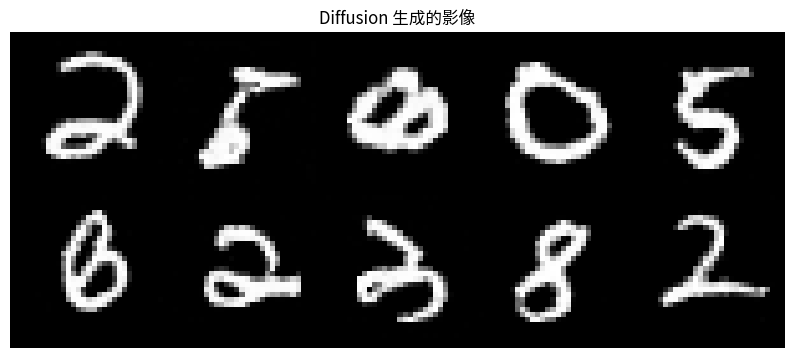

In [ ]:
# Diffusion 取樣
@torch.no_grad()
def sample_diffusion(num_samples):
    model_diff.eval()
    x = torch.randn(num_samples, channels, image_size, image_size).to(device)
    for t in reversed(range(timesteps)):
        t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
        predicted_noise = model_diff(x, t_tensor)
        alpha = alphas[t]
        alpha_cumprod = alphas_cumprod[t]
        beta = betas[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        alpha = alpha.expand(num_samples, channels, image_size, image_size)
        alpha_cumprod = alpha_cumprod.expand(num_samples, channels, image_size, image_size)
        beta = beta.expand(num_samples, channels, image_size, image_size)
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise) + torch.sqrt(beta) * noise
    return x.clamp(-1, 1)

diff_samples = sample_diffusion(10)
show_images(diff_samples, "Diffusion 生成的影像", nrow=5)

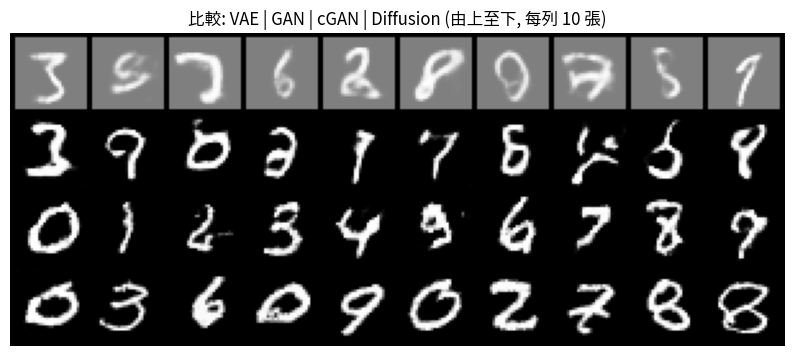

In [ ]:
# 比較
# 生成比較用的影像（每個模型生成 0-9 每個數字 1 張）
with torch.no_grad():
    # VAE 生成（使用 latent_dim=20）
    z_vae = torch.randn(10, latent_dim).to(device)
    vae_comp = vae.decode(z_vae)

    # GAN 生成（使用 noise_dim=100）
    z_gan = torch.randn(10, noise_dim).to(device)
    gan_comp = generator_gan(z_gan)

    # cGAN 生成，指定 0-9 的標籤（使用 noise_dim=100）
    labels_cgan = torch.arange(10, dtype=torch.long).to(device)
    z_cgan = torch.randn(10, noise_dim).to(device)
    cgan_comp = generator_cgan(z_cgan, labels_cgan)

    # Diffusion 生成（直接生成 10 張）
    diff_comp = sample_diffusion(10)

# 繪製比較圖
comp_images = torch.cat([vae_comp, gan_comp, cgan_comp, diff_comp])
show_images(comp_images, "比較: VAE | GAN | cGAN | Diffusion (由上至下, 每列 10 張)", nrow=10)

# 注意：分析部分請觀察清晰度、穩定性（GAN 是否有模式崩潰）、可控性（cGAN 可指定類別）、效率（訓練/推理時間）。